# Natural Language Processing

Started by following this excellent tutorial series from [TensorFlow on YouTube](https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S).

Before that, let's get some example text from my blog.

In [170]:
import glob
import re
from bs4 import BeautifulSoup

def get_dan_sentences():
    for filename in glob.glob('/Users/dan/Development/dantelore/hugo/public/posts/*/*.html'):
        html = None
        with open(filename) as f:
            html = f.read()
        if html:
            soup = BeautifulSoup(html, features='html.parser')

            # Remove code and preformatted blocks
            for x in soup.findAll('code'):
                x.extract()

            # Remove footers
            for x in soup.findAll('footer'):
                x.extract()

            # Remove header/nav
            for x in soup.findAll('nav'):
                x.extract()

            # Remove post list
            for x in soup.findAll('ul', {'id': 'post-list'}):
                x.extract()

            for p in soup.findAll('p'):    
                text = p.get_text()

                # Remove long whitespaces
                text = re.sub(r'\s+', ' ', text)

                # Remove non ASCII chars
                text = re.sub(r'[^\x00-\x7F]+', '', text)

                # Remove urls
                text = re.sub(r'http(s?)[^\s]+', ' ', text)

                text = text.replace('/n', 'URL')

                sentences = [x for x in re.split(r'[\.\?\!;:]+\s+', text) if len(x) > 10]
                for s in sentences:
                    yield s.strip()

sentences = list(get_dan_sentences())

# Tokenisation

In [171]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=2500, oov_token='<OOV>')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

max_length = 12

input_sequences = []

for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[max(i-max_length, 0):i+1]
        input_sequences.append(n_gram_sequence)

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_length, padding='pre'))

xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
# One-hot encode the output, as the words are categorical
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Wrap in a Pandas Dataframe just for nicer display
pd.set_option('display.min_rows', 10)
pd.DataFrame(xs)

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,48
2,0,0,0,0,0,0,0,0,1,48,10
3,0,0,0,0,0,0,0,1,48,10,11
4,0,0,0,0,0,0,1,48,10,11,292
...,...,...,...,...,...,...,...,...,...,...,...
38929,0,0,0,0,0,0,0,6,109,53,8
38930,0,0,0,0,0,0,6,109,53,8,46
38931,0,0,0,0,0,6,109,53,8,46,5378
38932,0,0,0,0,6,109,53,8,46,5378,14


# Training a replacement Dan

;)

In [180]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(total_words, 500, input_length=max_length - 1))
model.add(Bidirectional(LSTM(300)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(xs, ys, epochs=100, verbose=1)

Epoch 1/10


2023-01-17 15:04:06.638560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 15:04:06.946786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 15:04:06.961639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 15:04:07.162102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 15:04:07.185776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1217/1217 [==============================] - 35s 27ms/step - loss: 7.0075 - accuracy: 0.0742
Epoch 2/10
1217/1217 [==============================] - 32s 26ms/step - loss: 6.3299 - accuracy: 0.0954
Epoch 3/10
1217/1217 [==============================] - 32s 27ms/step - loss: 5.7616 - accuracy: 0.1158
Epoch 4/10
1217/1217 [==============================] - 33s 27ms/step - loss: 5.2880 - accuracy: 0.1362
Epoch 5/10
1217/1217 [==============================] - 32s 26ms/step - loss: 4.9151 - accuracy: 0.1546
Epoch 6/10
1217/1217 [==============================] - 32s 26ms/step - loss: 4.5991 - accuracy: 0.1770
Epoch 7/10
1217/1217 [==============================] - 32s 26ms/step - loss: 4.2788 - accuracy: 0.2042
Epoch 8/10
1217/1217 [==============================] - 32s 26ms/step - loss: 4.0657 - accuracy: 0.2250
Epoch 9/10
1217/1217 [==============================] - 32s 26ms/step - loss: 3.8982 - accuracy: 0.2433
Epoch 10/10
1217/1217 [==============================] - 31s 26ms/step - lo

dict_keys(['loss', 'accuracy'])


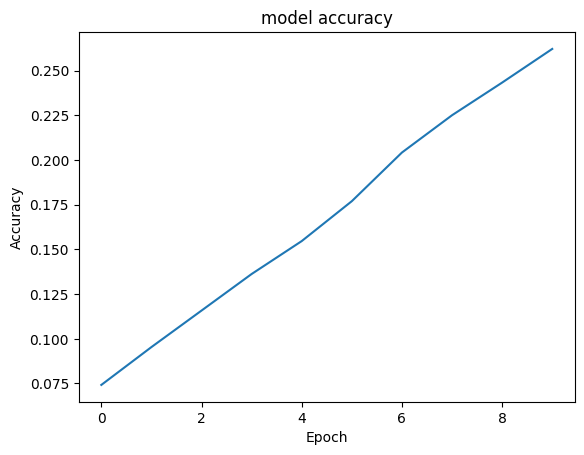

In [182]:
# Visualize training history
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# See how well the replacement Dan is working

In [184]:
seed_text = "what i really like about woodworking"
next_words = 20

word_lookup = {v: k for k, v in tokenizer.word_index.items()}

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=1)[0]
    output_word = word_lookup[predicted]
    seed_text += ' ' + output_word
print(seed_text)
    

what i really like about woodworking a little bit of the data strategy and practical guide to the top of the code data as much again
